In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

from pathlib import Path

import sys
current_dir = Path.cwd()
repo_root = current_dir.parent.parent  # Go up 1 levels
pdpo_path = str(repo_root.absolute())
# Add repository root to path
sys.path.insert(0, pdpo_path)

print(sys.path)



['/work2/Sebas/PDPO_jax', '/work2/Sebas/PDPO_jax/pdpo/spline', '/work2/Sebas/miniconda3/envs/PDPO_jax/lib/python313.zip', '/work2/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13', '/work2/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13/lib-dynload', '', '/work2/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13/site-packages']


In [2]:
# test_interpolation.ipynb

# Cell 1: Setup and Imports
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
from flax import nnx

# Import our interpolation functions
from pdpo.spline.interpolation import unstack_pytree, cubic_interp,linear_interpolation_states
from pdpo.models.nn import create_mlp

# Set random seeds for reproducibility
jax_key = jrandom.PRNGKey(42)
np.random.seed(42)

print("JAX version:", jax.__version__)


JAX version: 0.7.0


=== Test 2: MLP Parameters Interpolation ===


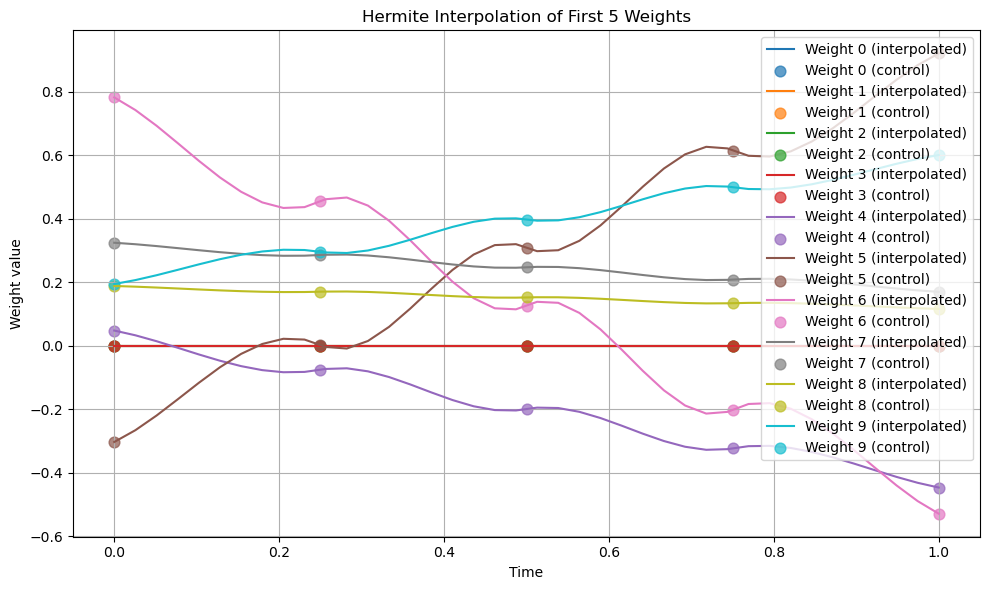

In [17]:
# Cell 3: Test 2 - MLP Parameters with Visualization
def test_mlp_parameters_interpolation():
    """Test interpolation with neural network parameters."""
    print("=== Test 2: MLP Parameters Interpolation ===")
    
    # Create MLP
    model0 = create_mlp(
        input_size=2,
        num_layers=3, 
        layer_width=4,
        activation='softplus',
        time_varying=True,
        key=jax_key
    )

    state0 = nnx.state(model0)
    key, subkey = jrandom.split(jax_key)

    model1 = create_mlp(
        input_size=2,
        num_layers=3, 
        layer_width=4,
        activation='softplus',
        time_varying=True,
        key=key
    )

    state1 = nnx.state(model1)

    t_control = jnp.linspace(0,1,5)
    
    s_query = jnp.linspace(0,1,40)
    

    initial = linear_interpolation_states(state0,state1,t_control)

    interpolation = unstack_pytree(cubic_interp(t_control,initial,s_query))

    def extract_first_k_weights(states, k=5):
        """
        Extracts the first k scalar weights from each PyTree state.
        Filters out non-array leaves (like strings).

        Args:
            states: list of PyTrees (e.g., nnx states)
            k: number of scalar weights to extract

        Returns:
            jnp.ndarray of shape [num_times, k]
        """
        flattened_series = []

        for state in states:
            flat_leaves = jax.tree.leaves(state)
            
            # Keep only JAX arrays (ignore strings, etc.)
            array_leaves = [leaf for leaf in flat_leaves if isinstance(leaf, jnp.ndarray)]

            # Flatten each array to 1D, concatenate all, and take first k scalars
            all_weights = jnp.concatenate([jnp.ravel(w) for w in array_leaves])
            flattened_series.append(all_weights[:k])

        return jnp.stack(flattened_series)  # shape [num_times, k]

    k = 10

    # Extract control and interpolated weights
    W_control = extract_first_k_weights(initial, k=k)
    W_interp = extract_first_k_weights(interpolation, k=k)

    # Plot
    plt.figure(figsize=(10, 6))
    for i in range(k):
        plt.plot(s_query, W_interp[:, i], label=f"Weight {i} (interpolated)")
        plt.scatter(t_control, W_control[:, i], s=60, marker='o', label=f"Weight {i} (control)", alpha=0.7)

    plt.xlabel("Time")
    plt.ylabel("Weight value")
    plt.title("Hermite Interpolation of First 5 Weights")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    

    
    

# Run the test
test_mlp_parameters_interpolation()

In [62]:
state_series = linear_interpolation_states(state0, state1, s_query)
interpolated_states = unstack_pytree(hermite_interpolate(s_query, state_series, ss_query))


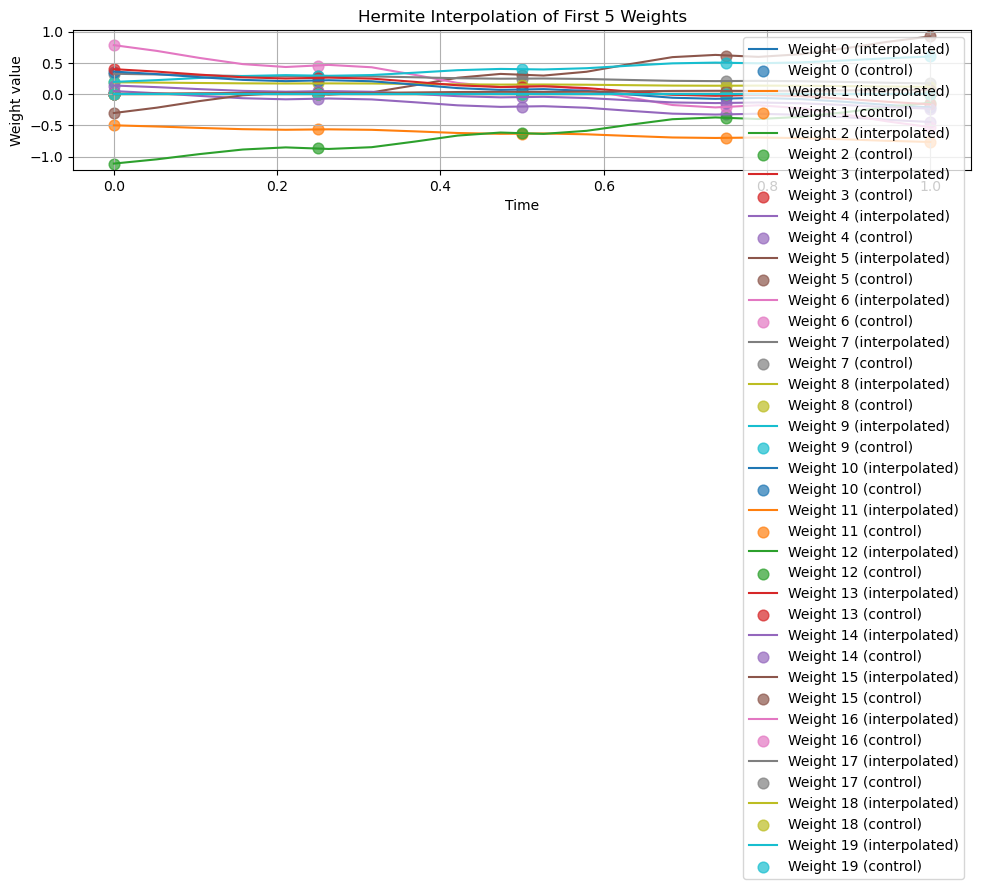

In [ ]:
import matplotlib.pyplot as plt
import jax

def extract_first_k_weights_batched(batched_state, k=20):
    """
    Extract first k weights from a batched PyTree of shape [T, ...].
    Assumes all leaves are stacked along axis 0.
    """
    T = jax.tree.leaves(batched_state)[0].shape[0]
    result = []

    for i in range(T):
        single_state = jax.tree.map(lambda x: x[i], batched_state)
        flat_leaves = jax.tree.leaves(single_state)
        array_leaves = [leaf for leaf in flat_leaves if isinstance(leaf, jnp.ndarray)]

        if not array_leaves:
            raise ValueError(f"No array-like leaves found in state index {i}.")

        all_weights = jnp.concatenate([jnp.ravel(w) for w in array_leaves])
        result.append(all_weights[:k])

    return jnp.stack(result)  # shape [T, k]


# Extract control and interpolated weights
W_control = extract_first_k_weights(state_series, k=20)
W_interp = extract_first_k_weights(interpolated_states, k=20)

# Plot
plt.figure(figsize=(10, 6))
for i in range(20):
    plt.plot(ss_query, W_interp[:, i], label=f"Weight {i} (interpolated)")
    plt.scatter(s_query, W_control[:, i], s=60, marker='o', label=f"Weight {i} (control)", alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Weight value")
plt.title("Hermite Interpolation of First 5 Weights")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
